In [1]:


#Imports and Setup
#
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, models, callbacks, Model
from tensorflow.keras.applications import EfficientNetV2B0, DenseNet121
from tensorflow.keras.models import load_model

print("All imports successful!")

2025-08-09 20:33:35.027439: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-09 20:33:35.034899: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754789615.043098   56170 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754789615.045543   56170 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754789615.051988   56170 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

All imports successful!


In [2]:
# GPU setup
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs detected: {gpus}")

# Set memory growth to avoid OOM errors
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Use multiple GPUs if available
if len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy()
    print(f"Using MirroredStrategy with {strategy.num_replicas_in_sync} GPUs")
else:
    strategy = tf.distribute.get_strategy()

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

print("GPU configuration complete!")

GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU configuration complete!


In [3]:
#  Ensemble Class Definition

class BurnClassificationEnsemble:
    """Production-ready ensemble for burn classification"""
    
    def __init__(self):
        self.models = {}
        self.model_weights = {}
        self.threshold = 0.35
        self.metadata = {}
        self.input_shape = (224, 224, 1)
        self.is_loaded = False
    
    def add_model(self, name, model, weight=1.0):
        """Add a model to the ensemble"""
        self.models[name] = model
        self.model_weights[name] = weight
    
    def set_threshold(self, threshold):
        """Set the classification threshold"""
        self.threshold = threshold
    
    def preprocess_image_for_ensemble(self, image_path):
        """Preprocess image for ensemble input (grayscale)"""
        try:
            # Load image as grayscale directly
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                raise ValueError(f"Could not load image: {image_path}")
            
            # Resize to target size
            img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
            
            # Add channel dimension for grayscale
            img = np.expand_dims(img, axis=-1)
            
            # Normalize to [0,1]
            img = img.astype(np.float32) / 255.0
            
            return img
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            return np.zeros((224, 224, 1), dtype=np.float32)
    
    def predict_proba(self, X):
        """Get ensemble probability predictions"""
        if not self.is_loaded:
            raise RuntimeError("Ensemble not loaded. Call load_ensemble() first.")
        
        if isinstance(X, str):
            # If X is a file path, preprocess it
            X = self.preprocess_image_for_ensemble(X)
            X = np.expand_dims(X, axis=0)
        elif isinstance(X, list):
            # If X is a list of file paths
            X = np.stack([self.preprocess_image_for_ensemble(path) for path in X])
        elif len(X.shape) == 3:
            X = np.expand_dims(X, axis=0)  # Add batch dimension if missing
        
        predictions = []
        total_weight = 0
        
        for name, model in self.models.items():
            try:
                pred = model.predict(X, verbose=0)
                weight = self.model_weights[name]
                predictions.append(pred * weight)
                total_weight += weight
            except Exception as e:
                print(f"Warning: Error predicting with model {name}: {e}")
                continue
        
        if not predictions:
            raise RuntimeError("No models could make predictions")
        
        # Weighted average
        ensemble_pred = np.sum(predictions, axis=0) / total_weight
        return ensemble_pred
    
    def predict(self, X):
        """Get binary predictions using threshold"""
        proba = self.predict_proba(X)
        return (proba >= self.threshold).astype(int)
    
    @classmethod
    def load_ensemble(cls, base_path):
        """Load a saved ensemble"""
        ensemble = cls()
        
        # Load metadata
        config_path = f"{base_path}/ensemble_config.json"
        with open(config_path, 'r') as f:
            config = json.load(f)
        
        print(f"Loading ensemble from: {base_path}")
        
        # Load models
        for name, model_path in config['model_paths'].items():
            try:
                model = load_model(model_path)
                weight = config['model_weights'][name]
                ensemble.add_model(name, model, weight)
                print(f"Loaded {name}")
            except Exception as e:
                print(f"ailed to load {name}: {e}")
        
        ensemble.set_threshold(config['threshold'])
        ensemble.input_shape = tuple(config.get('input_shape', (224, 224, 1)))
        ensemble.metadata = config.get('ensemble_metadata', {})
        ensemble.is_loaded = True
        
        print(f"Ensemble loaded successfully!")
        print(f"   Threshold: {ensemble.threshold}")
        print(f"   Models: {list(ensemble.models.keys())}")
        return ensemble

print("Ensemble class defined!")

Ensemble class defined!


In [4]:
# Load the ensemble instead of single model
print("Loading burn classification ensemble...")
try:
    model = BurnClassificationEnsemble.load_ensemble('burn_ensemble_models')
    print("Ensemble loaded successfully!")
    
    # Display ensemble info
    print(f"\nEnsemble Information:")
    print(f"   Number of models: {len(model.models)}")
    print(f"   Model names: {list(model.models.keys())}")
    print(f"   Classification threshold: {model.threshold}")
    print(f"   Expected input shape: {model.input_shape}")
    
except Exception as e:
    print(f"Error loading ensemble: {e}")
    print("Make sure 'burn_ensemble_models' directory exists with all model files")
    print("Required files:")
    print("  - ensemble_config.json")
    print("  - original_efficientnet_model.h5")
    print("  - efficient_b0_model.h5")
    print("  - efficient_b1_model.h5")
    print("  - resnet50_model.h5")
    print("  - densenet121_model.h5")

Loading burn classification ensemble...
Loading ensemble from: burn_ensemble_models


I0000 00:00:1754789616.358225   56170 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20160 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


Loaded original_efficientnet


Loaded efficient_b0


Loaded efficient_b1


Loaded resnet50


Loaded densenet121
Ensemble loaded successfully!
   Threshold: 0.35
   Models: ['original_efficientnet', 'efficient_b0', 'efficient_b1', 'resnet50', 'densenet121']
Ensemble loaded successfully!

Ensemble Information:
   Number of models: 5
   Model names: ['original_efficientnet', 'efficient_b0', 'efficient_b1', 'resnet50', 'densenet121']
   Classification threshold: 0.35
   Expected input shape: (224, 224, 1)


In [5]:
#Advanced Preprocessing Function
#
def advanced_preprocess_image_for_ensemble(image_path, target_size=IMG_SIZE):
    """Updated preprocessing function for ensemble (grayscale with advanced processing)"""
    try:
        # Load image as grayscale
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Could not load image: {image_path}")
        
        h, w = img.shape[:2]
        
        # Maintain aspect ratio
        aspect_ratio = w / h
        if aspect_ratio > 1:
            new_w = target_size[0]
            new_h = int(target_size[0] / aspect_ratio)
        else:
            new_h = target_size[1]
            new_w = int(target_size[1] * aspect_ratio)
        
        img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_CUBIC)
        
        # Add padding to reach target size
        delta_w = target_size[0] - new_w
        delta_h = target_size[1] - new_h
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)
        img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
        
        # Apply CLAHE for better contrast (match training preprocessing)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img = clahe.apply(img)
        
        # Add channel dimension and normalize
        img = np.expand_dims(img, axis=-1)
        img = img.astype(np.float32) / 255.0
        
        return img
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return np.zeros((*target_size, 1), dtype=np.float32)



print("Advanced preprocessing function defined!")



Advanced preprocessing function defined!


In [6]:
# Batch Prediction Function
def predict_images_with_ensemble(df, ensemble_model, threshold=None):
    """Updated prediction function for ensemble"""
    if threshold is None:
        threshold = ensemble_model.threshold

    
    print(f"Using threshold: {threshold}")
    print(f"Processing {len(df)} images in batches of {BATCH_SIZE}")
    
    all_preds = []
    all_probs = []
    
    for start in tqdm(range(0, len(df), BATCH_SIZE), desc="Processing batches"):
        end = min(start + BATCH_SIZE, len(df))
        batch_files = df['filepath'].iloc[start:end].tolist()
        
        # Preprocess batch images for ensemble
        batch_imgs = np.stack([advanced_preprocess_image_for_ensemble(f) for f in batch_files])
        
        # Get ensemble predictions
        batch_probs = ensemble_model.predict_proba(batch_imgs)
        all_probs.extend(batch_probs.flatten())
        
        # Apply threshold
        batch_preds = (batch_probs > threshold).astype(int).flatten()
        all_preds.extend(batch_preds)
    
    return np.array(all_preds), np.array(all_probs)

print("Batch prediction function defined!")

Batch prediction function defined!


In [7]:
# Load Unknown Data and Make Predictions
# 

# Load unknown data
df_unknown = pd.read_csv("burns_unknown_degree.csv")
print(f"Number of unknown burn images: {len(df_unknown)}")
print(f"Sample filepaths:")
print(df_unknown['filepath'].head())

# Check if files exist
missing_files = []
for filepath in df_unknown['filepath'].head(10):  # Check first 10
    if not os.path.exists(filepath):
        missing_files.append(filepath)

if missing_files:
    print(f"  Warning: {len(missing_files)} files not found (showing first few):")
    for f in missing_files[:5]:
        print(f"   {f}")
else:
    print(" All sample files found!")


Number of unknown burn images: 1227
Sample filepaths:
0     burn_dataset/img186.jpg
1    burn_dataset/img1048.jpg
2    burn_dataset/img1400.jpg
3     burn_dataset/img587.jpg
4     burn_dataset/img614.jpg
Name: filepath, dtype: object
 All sample files found!


In [8]:

#Run Predictions

# Make predictions with ensemble
print("Making predictions with ensemble...")
print("This may take a few minutes depending on the number of images...")

pred_labels, pred_probs = predict_images_with_ensemble(
    df_unknown, 
    model, 
    threshold=0.35  # Use medical-optimized threshold
)

print(f" Predictions complete!")
print(f"   Processed: {len(pred_labels)} images")
print(f"   3rd degree detected: {np.sum(pred_labels)}")
print(f"   1st/2nd degree: {len(pred_labels) - np.sum(pred_labels)}")


Making predictions with ensemble...
This may take a few minutes depending on the number of images...
Using threshold: 0.35
Processing 1227 images in batches of 16


Processing batches:   0%|                                             | 0/77 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1754789620.353824   56315 service.cc:152] XLA service 0x78ab84002980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754789620.353842   56315 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2025-08-09 20:33:40.399525: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754789620.687060   56315 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1754789622.981599   56315 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Processing batches:  99%|███████████████████████████████████▌| 76/77 [00:35<00:00,  3.98it/s]

Processing batches: 100%|████████████████████████████████████| 77/77 [00:50<00:00,  1.51it/s]

 Predictions complete!
   Processed: 1227 images
   3rd degree detected: 1203
   1st/2nd degree: 24


In [9]:
#Process Results and Save

# Add predictions to dataframe
df_unknown['predicted_label'] = pred_labels
df_unknown['predicted_prob'] = pred_probs
df_unknown['predicted_label_str'] = df_unknown['predicted_label'].map({
    0: "1st/2nd degree", 
    1: "3rd degree"
})

# Save results
output_file = "burns_unknown_labeled_ensemble.csv"
df_unknown.to_csv(output_file, index=False)
print(f" Saved: {output_file}")

# Show prediction distribution
print("\n Prediction Distribution:")
print(df_unknown['predicted_label_str'].value_counts())

 Saved: burns_unknown_labeled_ensemble.csv

 Prediction Distribution:
predicted_label_str
3rd degree        1203
1st/2nd degree      24
Name: count, dtype: int64


In [10]:



# Confidence analysis
print(f"\n Confidence Analysis:")
high_conf = df_unknown[df_unknown['predicted_prob'] > 0.7]
medium_conf = df_unknown[(df_unknown['predicted_prob'] >= 0.4) & (df_unknown['predicted_prob'] <= 0.7)]
low_conf = df_unknown[df_unknown['predicted_prob'] < 0.4]

print(f"   High confidence (>0.7): {len(high_conf)} images")
print(f"   Medium confidence (0.4-0.7): {len(medium_conf)} images") 
print(f"   Low confidence (<0.4): {len(low_conf)} images")

# Confidence by prediction
print(f"\n Confidence by Prediction:")
for label in [0, 1]:
    label_str = "1st/2nd degree" if label == 0 else "3rd degree"
    subset = df_unknown[df_unknown['predicted_label'] == label]
    if len(subset) > 0:
        avg_conf = subset['predicted_prob'].mean()
        min_conf = subset['predicted_prob'].min()
        max_conf = subset['predicted_prob'].max()
        print(f"   {label_str}: avg={avg_conf:.3f}, range=({min_conf:.3f}-{max_conf:.3f})")


 Confidence Analysis:
   High confidence (>0.7): 1 images
   Medium confidence (0.4-0.7): 1164 images
   Low confidence (<0.4): 62 images

 Confidence by Prediction:
   1st/2nd degree: avg=0.313, range=(0.279-0.350)
   3rd degree: avg=0.561, range=(0.351-0.703)


In [11]:
# Show some examples of each category
print(f"\n Example Cases:")

print(f"\n Low confidence cases (<0.4):")
if len(low_conf) > 0:
    display_cols = ['filepath', 'predicted_prob', 'predicted_label_str']
    print(low_conf[display_cols].head(10).to_string(index=False))
else:
    print("   No low confidence cases found")

print(f"\n High confidence 3rd degree cases (>0.7):")
high_conf_3rd = df_unknown[(df_unknown['predicted_prob'] > 0.7) & (df_unknown['predicted_label'] == 1)]
if len(high_conf_3rd) > 0:
    print(high_conf_3rd[display_cols].head(10).to_string(index=False))
else:
    print("   No high confidence 3rd degree cases found")

print(f"\n High confidence 1st/2nd degree cases (>0.7):")
high_conf_mild = df_unknown[(df_unknown['predicted_prob'] < 0.3) & (df_unknown['predicted_label'] == 0)]
if len(high_conf_mild) > 0:
    # For 1st/2nd degree, low probability = high confidence
    print(high_conf_mild[display_cols].head(10).to_string(index=False))
else:
    print("   No high confidence 1st/2nd degree cases found")


 Example Cases:

 Low confidence cases (<0.4):
                filepath  predicted_prob predicted_label_str
burn_dataset/img1400.jpg        0.350524          3rd degree
 burn_dataset/img671.jpg        0.364786          3rd degree
 burn_dataset/img703.jpg        0.336222      1st/2nd degree
 burn_dataset/img516.jpg        0.378623          3rd degree
 burn_dataset/img562.jpg        0.349014      1st/2nd degree
burn_dataset/img1137.jpg        0.372644          3rd degree
 burn_dataset/img596.jpg        0.368205          3rd degree
 burn_dataset/img895.jpg        0.376577          3rd degree
burn_dataset/img1429.jpg        0.288623      1st/2nd degree
 burn_dataset/img683.jpg        0.386713          3rd degree

 High confidence 3rd degree cases (>0.7):
               filepath  predicted_prob predicted_label_str
burn_dataset/img536.jpg        0.702811          3rd degree

 High confidence 1st/2nd degree cases (>0.7):
                filepath  predicted_prob predicted_label_str
burn_datas

In [12]:
print(f"\n" + "="*60)
print(f" FINAL SUMMARY")
print(f"="*60)

print(f" Dataset Statistics:")
print(f"   Total images processed: {len(df_unknown)}")
print(f"   3rd degree burns detected: {np.sum(pred_labels)} ({np.sum(pred_labels)/len(pred_labels)*100:.1f}%)")
print(f"   1st/2nd degree burns: {len(pred_labels) - np.sum(pred_labels)} ({(len(pred_labels) - np.sum(pred_labels))/len(pred_labels)*100:.1f}%)")

print(f"\n Confidence Metrics:")
print(f"   Average confidence: {np.mean(pred_probs):.3f}")
print(f"   Confidence std dev: {np.std(pred_probs):.3f}")
print(f"   Min confidence: {np.min(pred_probs):.3f}")
print(f"   Max confidence: {np.max(pred_probs):.3f}")

print(f"\n  Model Settings:")
print(f"   Ensemble threshold used: {model.threshold}")
print(f"   Number of models in ensemble: {len(model.models)}")
print(f"   Model names: {', '.join(model.models.keys())}")

print(f"\n Output Files:")
print(f"   Results saved to: {output_file}")
print(f"   Columns: {list(df_unknown.columns)}")

print(f"\n Processing Complete!")


 FINAL SUMMARY
 Dataset Statistics:
   Total images processed: 1227
   3rd degree burns detected: 1203 (98.0%)
   1st/2nd degree burns: 24 (2.0%)

 Confidence Metrics:
   Average confidence: 0.556
   Confidence std dev: 0.084
   Min confidence: 0.279
   Max confidence: 0.703

  Model Settings:
   Ensemble threshold used: 0.35
   Number of models in ensemble: 5
   Model names: original_efficientnet, efficient_b0, efficient_b1, resnet50, densenet121

 Output Files:
   Results saved to: burns_unknown_labeled_ensemble.csv
   Columns: ['filepath', 'label', 'predicted_label', 'predicted_prob', 'predicted_label_str']

 Processing Complete!


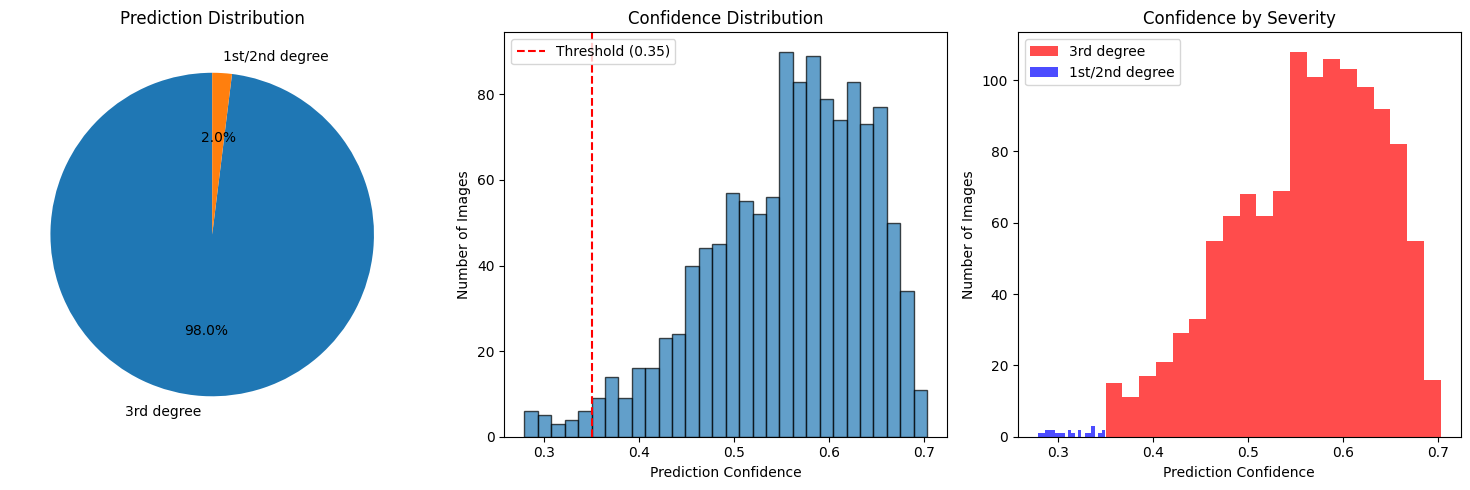

In [13]:
# Create visualizations
plt.figure(figsize=(15, 5))

# Subplot 1: Prediction distribution
plt.subplot(1, 3, 1)
pred_counts = df_unknown['predicted_label_str'].value_counts()
plt.pie(pred_counts.values, labels=pred_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Prediction Distribution')

# Subplot 2: Confidence histogram
plt.subplot(1, 3, 2)
plt.hist(pred_probs, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Prediction Confidence')
plt.ylabel('Number of Images')
plt.title('Confidence Distribution')
plt.axvline(x=model.threshold, color='red', linestyle='--', label=f'Threshold ({model.threshold})')
plt.legend()

# Subplot 3: Confidence by prediction
plt.subplot(1, 3, 3)
df_3rd = df_unknown[df_unknown['predicted_label'] == 1]['predicted_prob']
df_mild = df_unknown[df_unknown['predicted_label'] == 0]['predicted_prob']

if len(df_3rd) > 0:
    plt.hist(df_3rd, bins=20, alpha=0.7, label='3rd degree', color='red')
if len(df_mild) > 0:
    plt.hist(df_mild, bins=20, alpha=0.7, label='1st/2nd degree', color='blue')

plt.xlabel('Prediction Confidence')
plt.ylabel('Number of Images')
plt.title('Confidence by Severity')
plt.legend()

plt.tight_layout()
plt.show()



In [17]:


print("Creating expanded dataset for next model...")

# Load original labeled datasets
df_1and2 = pd.read_csv('burns_1and2.csv')  # original 1st/2nd degree
df_3 = pd.read_csv('burns_3rd.csv')         # original 3rd degree

print(f"Original datasets loaded:")
print(f"   1st/2nd degree: {len(df_1and2)} images")
print(f"   3rd degree: {len(df_3)} images")

# Ensure consistent column naming
if 'label' in df_1and2.columns:
    df_1and2 = df_1and2.rename(columns={'label': 'binary_label'})
if 'label' in df_3.columns:
    df_3 = df_3.rename(columns={'label': 'binary_label'})

# Standardize all labels to numeric 0/1
df_1and2['binary_label'] = 0  # All 1st/2nd degree
df_3['binary_label'] = 1      # All 3rd degree

# STRATEGY: Use balanced threshold + confidence filtering
balanced_threshold = 0.50  # More balanced severe/mild ratio
confidence_threshold = 0.60  # Only confident predictions

print(f"\n Using balanced approach:")
print(f"   Classification threshold: {balanced_threshold} (for balanced predictions)")
print(f"   Confidence threshold: {confidence_threshold} (for high-quality labels)")

# Reclassify with balanced threshold
df_unknown['balanced_label'] = (df_unknown['predicted_prob'] >= balanced_threshold).astype(int)

# Filter for high-confidence predictions only
high_conf = df_unknown[df_unknown['predicted_prob'] >= confidence_threshold].copy()
print(f"\nHigh-confidence predictions (>= {confidence_threshold}): {len(high_conf)} images")

# Show distribution with balanced threshold
balanced_severe = sum(df_unknown['balanced_label'])
balanced_mild = len(df_unknown) - balanced_severe
print(f"\nBalanced classification (threshold {balanced_threshold}):")
print(f"   3rd degree: {balanced_severe} ({balanced_severe/len(df_unknown)*100:.1f}%)")
print(f"   1st/2nd degree: {balanced_mild} ({balanced_mild/len(df_unknown)*100:.1f}%)")

if len(high_conf) == 0:
    print(" No high-confidence predictions found!")
    print("   Trying lower confidence threshold...")
    
    for thresh in [0.55, 0.50, 0.45]:
        high_conf_test = df_unknown[df_unknown['predicted_prob'] >= thresh]
        print(f"   At confidence {thresh}: {len(high_conf_test)} images")
        if len(high_conf_test) > 0:
            confidence_threshold = thresh
            high_conf = high_conf_test.copy()
            print(f"   Using confidence threshold {thresh}")
            break

# Use balanced labels for the high-confidence subset
high_conf['binary_label'] = high_conf['balanced_label']  # Use balanced threshold labels

# Show final high-confidence distribution
if len(high_conf) > 0:
    hc_severe = sum(high_conf['binary_label'])
    hc_mild = len(high_conf) - hc_severe
    print(f"\nHigh-confidence subset distribution:")
    print(f"   3rd degree: {hc_severe} ({hc_severe/len(high_conf)*100:.1f}%)")
    print(f"   1st/2nd degree: {hc_mild} ({hc_mild/len(high_conf)*100:.1f}%)")

# Keep only necessary columns for consistency
df_1and2 = df_1and2[['filepath', 'binary_label']]
df_3 = df_3[['filepath', 'binary_label']]
high_conf = high_conf[['filepath', 'binary_label']]

# Combine all datasets (original + new high-confidence predictions)
df_all = pd.concat([df_1and2, df_3, high_conf], ignore_index=True)

print(f"\n Final combined dataset:")
print(f"   Total images: {len(df_all)}")
print(f"   Class distribution:")
print(df_all['binary_label'].value_counts())

# Calculate what was added
original_total = len(df_1and2) + len(df_3)
added_images = len(high_conf)
print(f"\n Dataset expansion:")
print(f"   Original dataset: {original_total} images")
print(f"   Added from ensemble: {added_images} images")
print(f"   Growth: +{added_images/original_total*100:.1f}%")

# Save the expanded dataset 
df_all.to_csv('burns_dataset_expanded.csv', index=False)
print(f"\n Saved: burns_dataset_expanded.csv")
print(f"   Ready for your next model!")

# Verify the file format matches what your next model expects
print(f"\n File verification:")
print(f"   Columns: {list(df_all.columns)}")
print(f"   Sample rows:")
print(df_all.head(3))

# Show confidence distribution of added images
if len(high_conf) > 0:
    added_confidence = df_unknown[df_unknown['predicted_prob'] >= confidence_threshold]['predicted_prob']
    print(f"\n Confidence of added images:")
    print(f"   Mean: {added_confidence.mean():.3f}")
    print(f"   Min:  {added_confidence.min():.3f}")
    print(f"   Max:  {added_confidence.max():.3f}")


Creating expanded dataset for next model...
Original datasets loaded:
   1st/2nd degree: 4876 images
   3rd degree: 1023 images

 Using balanced approach:
   Classification threshold: 0.5 (for balanced predictions)
   Confidence threshold: 0.6 (for high-quality labels)

High-confidence predictions (>= 0.6): 429 images

Balanced classification (threshold 0.5):
   3rd degree: 930 (75.8%)
   1st/2nd degree: 297 (24.2%)

High-confidence subset distribution:
   3rd degree: 429 (100.0%)
   1st/2nd degree: 0 (0.0%)

 Final combined dataset:
   Total images: 6328
   Class distribution:
binary_label
0    4876
1    1452
Name: count, dtype: int64

 Dataset expansion:
   Original dataset: 5899 images
   Added from ensemble: 429 images
   Growth: +7.3%

 Saved: burns_dataset_expanded.csv
   Ready for your next model!

 File verification:
   Columns: ['filepath', 'binary_label']
   Sample rows:
                                            filepath  binary_label
0  alt_burn_dataset/skin burn dataset/t

In [18]:
# 
#  Results Quality Analysis
# 

print(" ANALYZING RESULTS QUALITY")
print("="*60)

# Load the results
df_results = pd.read_csv('burns_unknown_labeled_ensemble.csv')

print(f"Detailed Distribution Analysis:")
print(f"   Total images: {len(df_results)}")
print(f"   3rd degree: {sum(df_results['predicted_label'] == 1)} ({sum(df_results['predicted_label'] == 1)/len(df_results)*100:.1f}%)")
print(f"   1st/2nd degree: {sum(df_results['predicted_label'] == 0)} ({sum(df_results['predicted_label'] == 0)/len(df_results)*100:.1f}%)")

# Check confidence distribution
print(f"\n Confidence Analysis:")
conf_stats = df_results['predicted_prob'].describe()
print(conf_stats)

# Check if this makes sense by looking at boundary cases
print(f"\n Boundary Analysis (around threshold {model.threshold}):")
near_threshold = df_results[(df_results['predicted_prob'] >= 0.30) & (df_results['predicted_prob'] <= 0.40)]
print(f"   Images near threshold (0.30-0.40): {len(near_threshold)}")
print(f"   These are the most uncertain predictions")

# Look at the most confident predictions of each type
print(f"\n Most Confident Predictions:")

# Most confident 3rd degree
conf_3rd = df_results[df_results['predicted_label'] == 1].nlargest(5, 'predicted_prob')
print(f"\n   Top 5 Most Confident 3rd Degree:")
for idx, row in conf_3rd.iterrows():
    print(f"     {row['filepath']} - {row['predicted_prob']:.3f}")

# Most confident 1st/2nd degree (lowest probabilities)
conf_mild = df_results[df_results['predicted_label'] == 0].nsmallest(5, 'predicted_prob')
print(f"\n   Top 5 Most Confident 1st/2nd Degree:")
for idx, row in conf_mild.iterrows():
    print(f"     {row['filepath']} - {row['predicted_prob']:.3f}")

# Check for potential issues
print(f"\n POTENTIAL ISSUES TO INVESTIGATE:")

# Issue 1: Very skewed distribution
if sum(df_results['predicted_label'] == 1) / len(df_results) > 0.90:
    print(f"     98% severe burns seems unusually high")
    print(f"      - Is this dataset actually mostly severe burns?")
    print(f"      - Or is the model biased toward severe predictions?")

# Issue 2: Low confidence
max_conf = df_results['predicted_prob'].max()
if max_conf < 0.8:
    print(f"     Max confidence only {max_conf:.3f} - ensemble is not very sure")
    print(f"      - Model might not be well-suited for this data")
    print(f"      - Images might be different from training data")

# Issue 3: Threshold analysis
print(f"\n What happens at different thresholds?")
thresholds_to_test = [0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55]
print(f"{'Threshold':<10} {'3rd Degree':<12} {'1st/2nd':<10} {'% Severe'}")
print("-" * 45)

for thresh in thresholds_to_test:
    preds_at_thresh = (df_results['predicted_prob'] >= thresh).astype(int)
    severe_count = sum(preds_at_thresh)
    mild_count = len(preds_at_thresh) - severe_count
    severe_pct = severe_count / len(preds_at_thresh) * 100
    
    marker = " <- CURRENT" if thresh == model.threshold else ""
    print(f"{thresh:<10.2f} {severe_count:<12} {mild_count:<10} {severe_pct:<6.1f}%{marker}")

# Recommendations
print(f"\n RECOMMENDATIONS:")

if sum(df_results['predicted_label'] == 1) / len(df_results) > 0.95:
    print(f"    Consider using threshold 0.45 or 0.50 for more balanced predictions")
    
if max_conf < 0.75:
    print(f"    Manually check some predictions to see if they look correct")
    print(f"   Consider only using high-confidence predictions (>0.6) for training")

print(f"\n NEXT STEPS:")
print(f"   1. Visually inspect some predicted images")
print(f"   2. Try different thresholds if distribution seems wrong")
print(f"   3. Use only high-confidence predictions for expanding dataset")

# Show some random examples for manual inspection
print(f"\n RANDOM SAMPLE FOR MANUAL INSPECTION:")
sample_images = df_results.sample(10, random_state=42)
print(f"{'Filename':<25} {'Prediction':<15} {'Confidence'}")
print("-" * 55)
for idx, row in sample_images.iterrows():
    filename = row['filepath'].split('/')[-1]  # Just filename
    pred_str = row['predicted_label_str']
    conf = row['predicted_prob']
    print(f"{filename:<25} {pred_str:<15} {conf:.3f}")



 ANALYZING RESULTS QUALITY
Detailed Distribution Analysis:
   Total images: 1227
   3rd degree: 1203 (98.0%)
   1st/2nd degree: 24 (2.0%)

 Confidence Analysis:
count    1227.000000
mean        0.556212
std         0.084064
min         0.279382
25%         0.501415
50%         0.568811
75%         0.621411
max         0.702811
Name: predicted_prob, dtype: float64

 Boundary Analysis (around threshold 0.35):
   Images near threshold (0.30-0.40): 53
   These are the most uncertain predictions

 Most Confident Predictions:

   Top 5 Most Confident 3rd Degree:
     burn_dataset/img536.jpg - 0.703
     burn_dataset/img339.jpg - 0.699
     burn_dataset/img278.jpg - 0.698
     burn_dataset/img202.jpg - 0.697
     burn_dataset/img438.jpg - 0.697

   Top 5 Most Confident 1st/2nd Degree:
     burn_dataset/img272.jpg - 0.279
     burn_dataset/img44.jpg - 0.285
     burn_dataset/img1429.jpg - 0.289
     burn_dataset/img14.jpg - 0.289
     burn_dataset/img570.jpg - 0.290

 POTENTIAL ISSUES TO INVES